<a href="https://colab.research.google.com/github/andres-merino/AprendizajeAutomaticoInicial-05-N0105/blob/main/2-Ejercicios/04-Agrupamiento-kMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="border: none; border-collapse: collapse;">
    <tr>
        <td style="width: 20%; vertical-align: middle; padding-right: 10px;">
            <img src="https://i.imgur.com/nt7hloA.png" width="100">
        </td>
        <td style="width: 2px; text-align: center;">
            <font color="#0030A1" size="7">|</font><br>
            <font color="#0030A1" size="7">|</font>
        </td>
        <td>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="5">
                <b>Escuela de Ciencias Físicas y Matemática</b>
            </font> </p>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="4">
                Aprendizaje Automático Inicial &bull; Agrupamiento k-Means
            </font></p>
            <p style="font-style: oblique;"><font color="#0030A1" size="3">
                Melani Loor &bull; 2024-02
            </font></p>
        </td>  
    </tr>
</table>

---
## <font color='264CC7'> Introducción </font>

A lo largo de este taller, aplicaremos el algoritmo de agrupamiento jerárquico a un conjunto de datos.

Los paquetes necesarios son:

In [1]:
# Paquetes necesarios

import pandas as pd  # Manejo de datos
import numpy as np  # Operaciones matemáticas y arreglos
import matplotlib.pyplot as plt  # Visualización
import plotly.express as px # Para visualización interactiva

from sklearn.preprocessing import StandardScaler  # Estandarización de datos

from sklearn.datasets import make_blobs # Creación de datos de prueba
from sklearn.cluster import KMeans  # Algoritmo K-means
from sklearn.decomposition import PCA # Análisis de componentes principales

from sklearn.metrics import silhouette_score # Métricas de evaluación
from sklearn.manifold import TSNE # Reducción de dimensionalidad


---
## <font color='264CC7'> Preprocesamiento de datos </font>

Primero necesitas el conjunto de datos. Los datos a utilzar son los seleccionados en la clase aterior.

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Carga el conjunto de datos y procésalos:
<ul>
  <li>Muestra algunos datos.</li>
  <li>Muestra una descripción de los datos.</li>
  <li>Escala los datos si es necesario.</li>
</ul>
</div>

**Carga de datos**

In [2]:
# Leer los datos
data = pd.read_csv('https://raw.githubusercontent.com/mnloor/Aprendizaje-Automatico/refs/heads/main/Datos/1-%20mental-illnesses-prevalence.csv')

data.rename(columns={
    'Entity': 'País',
    'Code': 'Código',
    'Year': 'Anio',
    'Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized': 'Esquizofrenia',
    'Depressive disorders (share of population) - Sex: Both - Age: Age-standardized': 'Depresión',
    'Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized': 'Ansiedad',
    'Bipolar disorders (share of population) - Sex: Both - Age: Age-standardized': 'Trastorno Bipolar',
    'Eating disorders (share of population) - Sex: Both - Age: Age-standardized': 'Trastorno Alimenticio'
}, inplace=True)

# Verificar nombres de columnas
data.columns

data = data[data['Anio'] == 2011]

# Tomo las columnas de interés
numeric_cols = ['Esquizofrenia', 'Depresión', 'Ansiedad', 'Trastorno Bipolar', 'Trastorno Alimenticio']
data = data[['País', *numeric_cols]]

# Muestro los primeros registros
display(data.head())

,País,Esquizofrenia,Depresión,Ansiedad,Trastorno Bipolar,Trastorno Alimenticio
21,Afghanistan,0.216218,4.945379,4.715658,0.699392,0.107169
51,Africa (IHME GBD),0.219953,4.488090,3.689709,0.604527,0.115847
81,Albania,0.285579,2.441195,3.767038,0.542330,0.124728
111,Algeria,0.248350,4.051072,4.670081,0.756370,0.201481
141,America (IHME GBD),0.342383,3.664557,5.665880,0.840436,0.304766


**Descripción de los datos**

In [3]:
data.describe()

,Esquizofrenia,Depresión,Ansiedad,Trastorno Bipolar,Trastorno Alimenticio
count,214.000000,214.000000,214.000000,214.000000,214.000000
mean,0.267354,3.713053,4.127244,0.637699,0.204274
std,0.039896,0.930430,1.083103,0.234761,0.146004
min,0.188597,1.525051,1.882687,0.182025,0.044780
25%,0.241687,3.009873,3.436885,0.520765,0.099475
50%,0.273864,3.575002,3.977787,0.578972,0.148526
75%,0.286799,4.358166,4.547295,0.843415,0.265535
max,0.458543,6.931850,8.370385,1.506619,0.997994


**Escalar los datos**

In [4]:
# Escalar los datos
scaler = StandardScaler()
X = scaler.fit_transform(data.iloc[:, 1:])

---
## <font color='264CC7'> Determinación del número de clusters </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Determina el número óptimo de clústeres para un modelo K-Means utilizando el método del codo.
<ul>
  <li>Genera una gráfica que muestre la inercia frente al número de clústeres (k) en el rango de 1 a 10.</li>
  <li>Identifica visualmente el "codo" en la curva para seleccionar el número óptimo de clústeres.</li>
  <li>De manera intuitiva, explica por qué consideras ese punto como el codo y cómo influye en la calidad de los clústeres.</li>
</ul>
</div>


**Inercia frente al número de clústers**

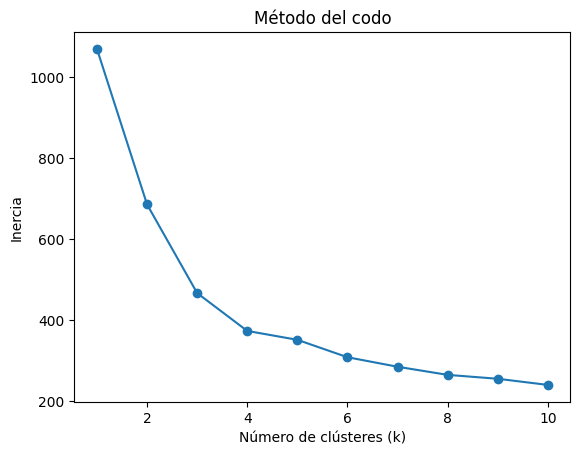

In [7]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Inercia')
plt.title('Método del codo')
plt.show()

**Interpretación**

De manera intuitiva voy a escoger 4 clústers por el rompimiento del codo, esto indica que a partir del punto 4 (k) no mejora significativamente la inercia así añada más clústers para mi análisis.

---
## <font color='264CC7'> Asignación de grupos y análisis </font>


<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Realiza un análisis de los grupos obtenidos.
<ul>
  <li>Asigna los grupos.</li>
  <li>Revisa la media de cada grupo.</li>
  <li>Revisa el mínimo y máximo de cada grupo.</li>
  <li>Muestra algunos integrantes de cada grupo.</li>
</ul>
</div>

**Asignación de grupos**

In [20]:
# Realizamos el agrupamiento
modelo = KMeans(n_clusters=4, random_state=42)
modelo.fit(X)

# Asignamos las etiquetas
labels = modelo.labels_

# Agregar la información de clúster como C1, C2, C3, etc.
data['Cluster'] = ['C' + str(c) for c in labels]

# Revisar los primeros registros
display(data.head())

,País,Esquizofrenia,Depresión,Ansiedad,Trastorno Bipolar,Trastorno Alimenticio,Cluster
21,Afghanistan,0.216218,4.945379,4.715658,0.699392,0.107169,C0
51,Africa (IHME GBD),0.219953,4.488090,3.689709,0.604527,0.115847,C0
81,Albania,0.285579,2.441195,3.767038,0.542330,0.124728,C3
111,Algeria,0.248350,4.051072,4.670081,0.756370,0.201481,C2
141,America (IHME GBD),0.342383,3.664557,5.665880,0.840436,0.304766,C1


**Elementos por clústers**

In [21]:
# Cantidades de elementos por clúster
data['Cluster'].value_counts()

,count
Cluster,
C3,75
C2,57
C0,54
C1,28


**Media de cada grupo**

In [22]:
# Podemos ver las medias de cada clúster
data.groupby('Cluster')[numeric_cols].mean()

,Esquizofrenia,Depresión,Ansiedad,Trastorno Bipolar,Trastorno Alimenticio
Cluster,,,,,
C0,0.214741,4.711889,3.599508,0.574464,0.105556
C1,0.306470,4.003641,6.110531,0.899561,0.465342
C2,0.273321,3.547005,4.494213,0.868039,0.263875
C3,0.286098,3.011603,3.487890,0.410409,0.132588


**Mínimo y máximo de cada grupo**

In [23]:
# Mínimo y máximo de cada grupo
display(data.groupby('Cluster')[numeric_cols].agg(['min', 'max']))

Esquizofrenia           Depresión            Ansiedad            \
                  min       max       min       max       min       max   
Cluster                                                                   
C0           0.188597  0.269783  3.342535  6.931850  2.648024  5.502382   
C1           0.252730  0.458543  2.969386  6.160037  4.755731  8.370385   
C2           0.240981  0.312674  2.161399  5.051435  3.560821  6.159831   
C3           0.254628  0.328624  1.525051  4.572979  1.882687  4.596523   

        Trastorno Bipolar           Trastorno Alimenticio            
                      min       max                   min       max  
Cluster                                                              
C0               0.384410  0.791091              0.044780  0.222390  
C1               0.602031  1.506619              0.219535  0.997994  
C2               0.676390  1.094929              0.119126  0.471922  
C3               0.182025  0.718122              0.064245  0.432644

**Algunos integrantes por cada grupo**

In [24]:
for cluster in data['Cluster'].unique():
    print(f'Cluster {cluster}: cantidad de elementos {data[data["Cluster"] == cluster].shape[0]}')
    display(data[data['Cluster'] == cluster].head(5))

Cluster C0: cantidad de elementos 54


,País,Esquizofrenia,Depresión,Ansiedad,Trastorno Bipolar,Trastorno Alimenticio,Cluster
21,Afghanistan,0.216218,4.945379,4.715658,0.699392,0.107169,C0
51,Africa (IHME GBD),0.219953,4.488090,3.689709,0.604527,0.115847,C0
231,Angola,0.216881,5.749008,3.978852,0.553895,0.125789,C0
681,Benin,0.212036,4.435290,3.169083,0.545644,0.094171,C0
831,Botswana,0.222172,4.268684,3.534371,0.540930,0.164485,C0


Cluster C3: cantidad de elementos 75


,País,Esquizofrenia,Depresión,Ansiedad,Trastorno Bipolar,Trastorno Alimenticio,Cluster
81,Albania,0.285579,2.441195,3.767038,0.542330,0.124728,C3
171,American Samoa,0.307144,2.616261,3.999533,0.279724,0.128153,C3
321,Armenia,0.279820,2.904648,3.149556,0.541904,0.115844,C3
351,Asia (IHME GBD),0.290621,3.151999,3.261816,0.331079,0.121679,C3
441,Azerbaijan,0.279375,2.673532,2.532916,0.522448,0.131308,C3


Cluster C2: cantidad de elementos 57


,País,Esquizofrenia,Depresión,Ansiedad,Trastorno Bipolar,Trastorno Alimenticio,Cluster
111,Algeria,0.248350,4.051072,4.670081,0.756370,0.201481,C2
261,Antigua and Barbuda,0.287932,2.849617,4.303295,0.946242,0.269954,C2
291,Argentina,0.312662,2.414126,4.897788,1.039076,0.318238,C2
471,Bahamas,0.285288,2.925142,4.282254,0.899375,0.297703,C2
501,Bahrain,0.271523,4.614372,4.920335,0.776609,0.273384,C2


Cluster C1: cantidad de elementos 28


,País,Esquizofrenia,Depresión,Ansiedad,Trastorno Bipolar,Trastorno Alimenticio,Cluster
141,America (IHME GBD),0.342383,3.664557,5.665880,0.840436,0.304766,C1
201,Andorra,0.287029,3.547046,5.412389,0.935904,0.520345,C1
381,Australia,0.388511,4.661994,5.605869,1.125039,0.997994,C1
411,Austria,0.275605,3.092570,5.919340,0.901901,0.555027,C1
861,Brazil,0.277096,3.928555,8.370385,1.112178,0.222514,C1


<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Da una descripción de los grupos obtenidos. Asigna un nombre a cada grupo.
</div>

1. **Clúster C0: Países con depresión moderada y trastornos bajos**

* Descripción: Este grupo incluye países con niveles bajos de esquizofrenia, ansiedad, trastornos bipolares y alimenticios. La depresión es el trastorno más destacado, pero se mantiene en niveles moderados.
* Ejemplo: Afganistán, Angola, Botsuana.

2. **Clúster C3: Países con trastornos leves y equilibrados**

* Descripción: Países con niveles bajos de esquizofrenia, depresión, ansiedad, y trastornos alimenticios. Son los países con las características más balanceadas, sin ningún trastorno predominante.
* Ejemplo: Albania, Armenia, Azerbaiyán.

3. **Clúster C2: Países con ansiedad y bipolaridad moderadamente altas**

* Descripción: Este grupo incluye países con niveles algo más elevados de ansiedad y trastornos bipolares, acompañados de niveles moderados de esquizofrenia y depresión. Los trastornos alimenticios también son más altos que en otros grupos.
* Ejemplo: Argelia, Argentina, Bahamas.

4. **Clúster C1: Países con ansiedad alta y otros trastornos graves**

* Descripción: Este clúster destaca por tener los niveles más altos de ansiedad, bipolaridad y trastornos alimenticios, junto con valores elevados de depresión. Representa los casos más graves.
* Ejemplo: Australia, Brasil, Austria.

---
## <font color='264CC7'> Visualizaciones  </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Realiza una visualización de los grupos obtenidos en 2D seleccionando dos variables que creas relevantes.
<ul>
  <li>¿Qué tan buenos te parecen los grupos?</li>
</ul>
</div>

In [25]:
fig = px.scatter(data, x='Trastorno Alimenticio', y='Depresión', color='Cluster', hover_data=['País'])
fig.show()

Los grupos se ven un bien separados en términos de depresión y trastorno alimenticio, especialmente el grupo C0 con valores altos y C3 con valores bajos. Sin embargo, no existe una clara agrupación de los países en los clústers tomando en cuenta solo la depresión y el transtorno alimenticio dado que hay una mezcla entre todos los grupos, lo que puede hacerlos menos claros. Además, existe una distribución uniforme en cuanto al número de países por clústers.

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Realiza una visualización de los grupos obtenidos en 2D usando reducción de dimensionalidad diferente a PCA.
<ul>
  <li>¿Qué tan buenos te parecen los grupos?</li>
</ul>
</div>

In [19]:
# Reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Crear un DataFrame para graficar fácilmente
df_tsne = pd.DataFrame(X_tsne, columns=['Componente 1', 'Componente 2'])
df_tsne['País'] = data['País'].values
df_tsne['Cluster'] = data['Cluster'].values

# Crear el scatterplot interactivo con Plotly Express
fig_tsne = px.scatter(
    df_tsne,
    x='Componente 1',
    y='Componente 2',
    color='Cluster',
    hover_data=['País'],
)

# Personalizar apariencia
fig_tsne.update_traces(marker=dict(opacity=0.8))
fig_tsne.update_layout(
    title='Clústeres visualizados en 2D (t-SNE)',
    width=800,
    height=600,
)

fig_tsne.show()


El gráfico muestra que los clústeres están bien diferenciados por lo que me parecen bastante buenos los grupos. Se tiene C0  como el grupo más grande y compacto, representando países con depresión moderada y otros trastornos bajos. C3 también está bien definido en la parte superior, reflejando países con trastornos leves y equilibrados. C2 está en la parte inferior y destaca, agrupando países con ansiedad y bipolaridad moderadamente altas. Por último, C1, aunque más pequeño, está claramente separado y agrupa países con ansiedad alta y otros trastornos graves, aunque su cercanía a C2 podría indicar características compartidas entre algunos países de ambos clústeres.


---
## <font color='264CC7'> Métricas  </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
Calcula la métrica de la silueta para los grupos obtenidos. ¿Qué tan buenos te parecen los grupos?
</div>

In [28]:
# Calcular la métrica de la silueta
silhouette_avg = silhouette_score(X, labels)
print(f"El puntaje promedio de silueta para k = 4 es: {silhouette_avg}")

El puntaje promedio de silueta para k = 4 es: 0.3947908849859219


El puntaje promedio de silueta obtenido, 0.39, indica que los clústeres tienen una separación moderada, pero no óptima. En general, un puntaje cercano a 1 sugiere que los puntos están bien agrupados y claramente separados de otros clústeres, mientras que un puntaje cercano a 0 indica que los puntos están cerca de los límites entre grupos. En este caso, el valor sugiere que algunos clústeres están bien definidos, pero hay cierta superposición entre otros, como podría ser entre C1 y C2.